# CLgen Sampling
-----
Dec 2016.

In [1]:
# preamble
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from labm8 import fs
from labm8 import viz

import clgen
from clgen import corpus

plt.style.use(["seaborn-white", "seaborn-paper"])

## 1. Experimental methodology

Experimental platforms: cc[123]. NVIDIA GTX 1080.

* Train on GitHub corpus.
* For each in top 20 most frequently occuring prototypes:
  * Generate 2000 sample with argspec.
  * Reject bad samples.

Commands:

```
$ export CUDA_VISIBLE_DEVICES=0
$ export MODEL=model-128x3x50
$ cd ~/phd/lab/clgen/inference
$ python ./inference.py $MODEL.json 2>&1 | tee inference-$MODEL.log
```

### Corpus

In [2]:
c = corpus.Corpus.from_json({"path": "~/data/github"})
print("CLgen:      ", clgen.version())
print("Corpus size:", c.size)
print("Vocab size: ", c.vocab_size)

CLgen:       0.2.1
Corpus size: 20271852
Vocab size:  92


### Prototypes

#. unique prototypes in corpus: 2186

Label	Ratio	Arguments
A	13.22%	'const int a, __global int* b, __global int* c'
B	9.42%	''
C	3.48%	'__global int* a'
D	3.43%	'__global float* a, __global float* b, __global float* c'
E	2.29%	'__global int* a, __global int* b'
F	1.97%	'__global float* a, __global float* b, __global int* c'
G	1.83%	'__global float* a, __global float* b'
H	1.78%	'__global float4* a, __global float4* b, __global float4* c, __global float4* d, __global float4* e, float f'
I	1.69%	'__local int* a'
J	1.28%	'__global float* a'
K	1.01%	'__global uint* a, __global uint* b'
L	0.87%	'__global int* a, __global int* b, __global int* c'
M	0.78%	'__global float4* a, __global float4* b, __global float4* c, __global float4* d, int e, int f, float g, float h'
N	0.78%	'__global float4* q, __global float4* r, __global float4* s, __global float4* t, int u, int e, int v, float f, float g, float h, float i, float j'
O	0.69%	'__global const float* a, __global const float* b, __global float*

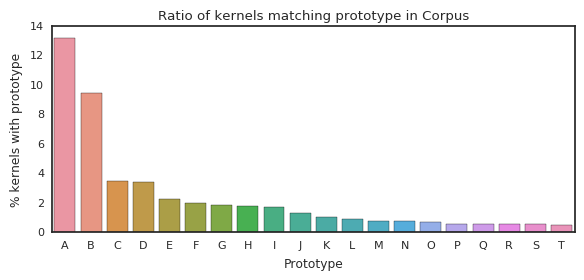

In [3]:
def proto_label(key, value):
    # return ', '.join(re.sub('_', '', x) for x in value['argspec'])
    return chr(ord('A') - 1 + int(key[0]))

p, num_prototypes = corpus.most_common_prototypes(c, 20)
prototypes = [x[1] for x in p]
print("#. unique prototypes in corpus:", num_prototypes)
print()
print("Label\tRatio\tArguments")
d = []
for i, row in enumerate(p):
    ratio, prototype = row
    label = proto_label((i + 1,), {})
    d.append({"prototype": label, "ratio": ratio * 100})
    print("{label}\t{ratio:.2f}%\t'{prototype}'"
          .format(label=label, ratio=ratio * 100, prototype=prototype))

sns.barplot(x="prototype", y="ratio", data=pd.DataFrame(d))
plt.title("Ratio of kernels matching prototype in Corpus")
plt.xlabel("Prototype")
plt.ylabel("% kernels with prototype")

viz.finalise(figsize=(6, 3))

## 2. Experimental results

In [4]:
def model_label(key, value):
    return '-'.join(key[1:])

def parse_file(path):
    """ return prototype index, model size, num layers, and epochs """
    import re
    m = re.search(r"p([0-9]+)-model-([0-9]+)x([0-9]+)x([0-9]+)", path)
    return m.group(1), m.group(2), m.group(3), m.group(4) 

data_files = ["inference/" + x for x in fs.ls("inference")
              if x.startswith("inference-p") and x.endswith(".json")]
data = dict((parse_file(x), clgen.load_json_file(x)) for x in data_files)
sorted_keys = sorted(data.keys(), key=lambda x: [int(y) for y in x])
print("read {} data files".format(len(data)))

read 14 data files


## 3. Evaluation

### Ability to generate kernels matching prototype

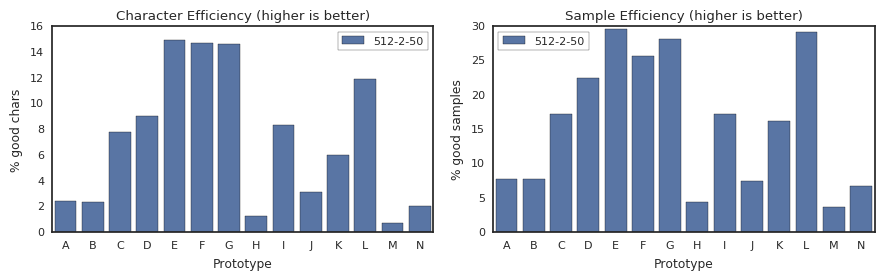

In [5]:
ax = plt.subplot(1, 2, 1)
d = pd.DataFrame([{
    "prototype": proto_label(x, data[x]),
    "efficiency": (data[x]["good_charcount"] / data[x]["total_charcount"]) * 100,
    "model": model_label(x, data[x])
} for x in sorted_keys])
sns.barplot(x="prototype", y="efficiency", hue="model", data=d)
plt.title("Character Efficiency (higher is better)")
plt.xlabel("Prototype")
plt.ylabel("% good chars")
ax.get_legend().set_title("")  # no legend title
ax.get_legend().draw_frame(True)

ax = plt.subplot(1, 2, 2)
d = pd.DataFrame([{
    "prototype": proto_label(x, data[x]),
    "efficiency": (data[x]["num_good_kernels"] / data[x]["num_kernels"]) * 100,
    "model": model_label(x, data[x])
} for x in sorted_keys])
sns.barplot(x="prototype", y="efficiency", hue="model", data=d)
plt.title("Sample Efficiency (higher is better)")
plt.xlabel("Prototype")
plt.ylabel("% good samples")
ax.get_legend().set_title("")  # no legend title
ax.get_legend().draw_frame(True)

viz.finalise(figsize=(9, 3))

### Sample size

In [6]:
# TODO: